#Get data from drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

In [ ]:
!ls "/content/drive/My Drive"

 0EAA4A-1_sdf_CHA.txt			    mit_denoised_ecg_emd_lead1.parquet
 0EAA4A-1_sdf_CHB.txt			    mit_denoised_ecg_lead0.parquet
'Colab Notebooks'			    mit_denoised_ecg_lead1.parquet
 data_glasgow				    Reflections_medicomp
 denoised_0EAA4A-1_sdf_CHA.csv		    ten-class-data.parquet
 denoised_0EAA4A-1_sdf_CHB.txt		    TrainingSet1
 ecg_denoised_df_refl_0.parquet		    TrainingSet2
 lstm.h5				    TrainingSet3
 mit_denoised_and_peaks_ecg_lead0.parquet   unet1d_new.h5
 mit_denoised_ecg_emd_lead0.parquet


In [ ]:
peak_detect_nw_path = '/content/drive/My Drive/lstm.h5'
reflections_txt_datapath_1 = '/content/drive/My Drive/0EAA4A-1_sdf_CHA.txt'
reflections_txt_datapath_2 = '/content/drive/My Drive/0EAA4A-1_sdf_CHB.txt'
glasgow_path = '/content/drive/My Drive/data_glasgow/'
model_path = '/content/drive/My Drive/unet1d_new.h5'

In [ ]:
!pip install -q wfdb

     |████████████████████████████████| 122kB 7.1MB/s 
     |████████████████████████████████| 6.8MB 29.7MB/s 
     |████████████████████████████████| 163kB 45.9MB/s 


#Denoising

##Data acquisition and Preparation

(827, 4096, 12)
(3600,)


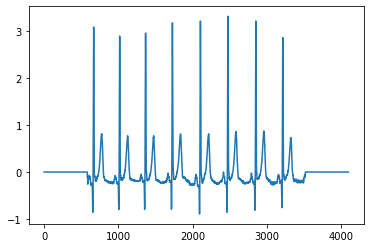

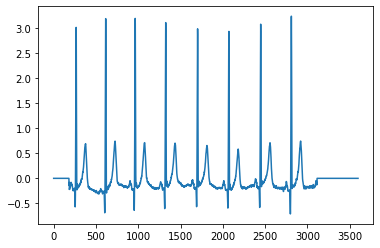

In [ ]:
import h5py
import numpy as np

f = h5py.File(glasgow_path + 'ecg_tracings.hdf5','r')
x = np.array(f['tracings'])
print(x.shape)

from matplotlib import pyplot as plt
plt.plot(x[0,:,0])
plt.figure()
plt.plot(x[0,:,11][400:4000])

print(x[0,:,10][400:4000].shape)
ecg = x[0,:,11]

###Prepare ground truth data: 1500 ECG tracings comprising of all leads

(3600,)


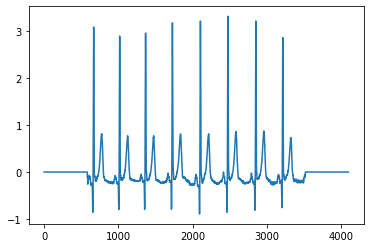

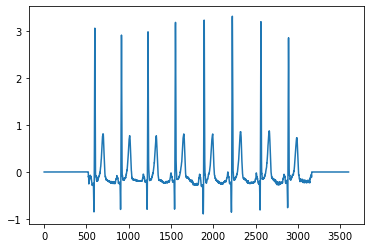

In [ ]:
#showing downsampling of 1 signal

from scipy.signal import resample_poly

ecg_orig = x[0,:,0]
plt.plot(x[0,:,0])

downsampled_ecg = resample_poly(ecg_orig,up = 360,down=400)
plt.figure()
plt.plot(downsampled_ecg[:3600]) #truncating to 3600 samples
downsampled_ecg = resample_poly(ecg_orig,up = 360,down=400)
print(downsampled_ecg[:3600].shape)

In [ ]:
import random
from sklearn.utils import shuffle
from scipy.signal import resample_poly
ground_truth_ecg = []

for i in range(12):
  lead_tracings = x[:,:,i]
  selected = random.sample(list(lead_tracings), 125)
  for j in range(len(selected)):
    ground_truth_ecg.append(resample_poly(selected[j],up = 360,down=400)[:3600])

ground_truth_ecg = shuffle(np.array(ground_truth_ecg))
print(ground_truth_ecg.shape)

(1500, 3600)


In [ ]:
####wrong


import random
from sklearn.utils import shuffle

ground_truth_ecg = []

for i in range(12):
  lead_tracings = x[:,:,i]
  selected = random.sample(list(lead_tracings), 125)
  for j in range(len(selected)):
    ground_truth_ecg.append(selected[j][400:4000])

ground_truth_ecg = shuffle(np.array(ground_truth_ecg))
print(ground_truth_ecg.shape)

(1500, 3600)


In [ ]:
np.save('./ground_truth_ecg.npy',ground_truth_ecg)

###Visualize noise from NSTDB

In [ ]:
import wfdb
from matplotlib import pyplot as plt
from wfdb import rdsamp
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

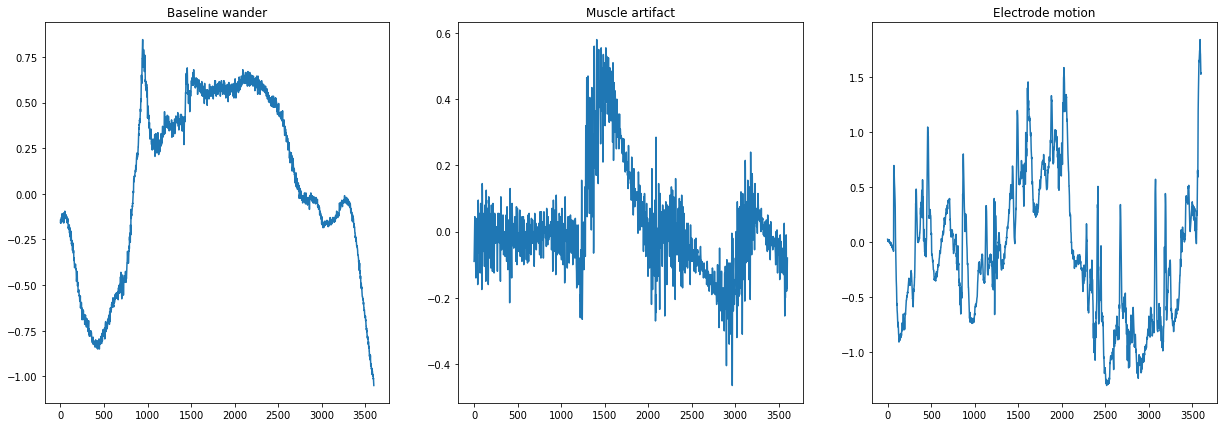

In [ ]:
# Load data
baseline_wander = rdsamp('bw', pn_dir='nstdb')
muscle_artifact = rdsamp('ma', pn_dir='nstdb')
electrode_motion = rdsamp('em', pn_dir='nstdb')

# Concatenate two channels to make one longer recording
ma = np.concatenate((muscle_artifact[0][:,0], muscle_artifact[0][:,1]))
bw = np.concatenate((baseline_wander[0][:,0], baseline_wander[0][:,1]))
em = np.concatenate((electrode_motion[0][:,0], electrode_motion[0][:,1]))

# Plot examples of baseline wandering and muscle artifact noise types
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(7), fig.set_figwidth(21)
ax1.plot(bw[:3600])
ax1.set_title('Baseline wander')
ax2.plot(ma[:3600])
ax2.set_title('Muscle artifact')
ax3.plot(em[:3600])
ax3.set_title('Electrode motion')
plt.show()

###Prepare noisy ECG

In [ ]:
def getNoisyECG(ma_mult,bw_mult,em_mult):
  temp_list = []
  '''
  beg = np.random.randint(ma.shape[0]-3600)
  end = beg + 3600
  beg2 = np.random.randint(bw.shape[0]-3600)
  end2 = beg2 + 3600
  beg3 = np.random.randint(em.shape[0]-3600)
  end3 = beg3 + 3600
  '''
  for i in range(len(ground_truth_ecg)):
    temp_list.append(ground_truth_ecg[i] + (ma_mult*ma[:3600] + bw_mult*bw[:3600] + em_mult*em[:3600]))
  return temp_list

ma_dom_group = np.array(getNoisyECG(0.6,0.2,0.2))
bw_dom_group = np.array(getNoisyECG(0.2,0.6,0.2))
em_dom_group = np.array(getNoisyECG(0.2,0.2,0.6))
print(ma_dom_group.shape,bw_dom_group.shape,em_dom_group.shape)

(1500, 3600) (1500, 3600) (1500, 3600)


In [ ]:
np.save('./ma_dom_group.npy',ma_dom_group)
np.save('./bw_dom_group.npy',bw_dom_group)
np.save('./em_dom_group.npy',em_dom_group)

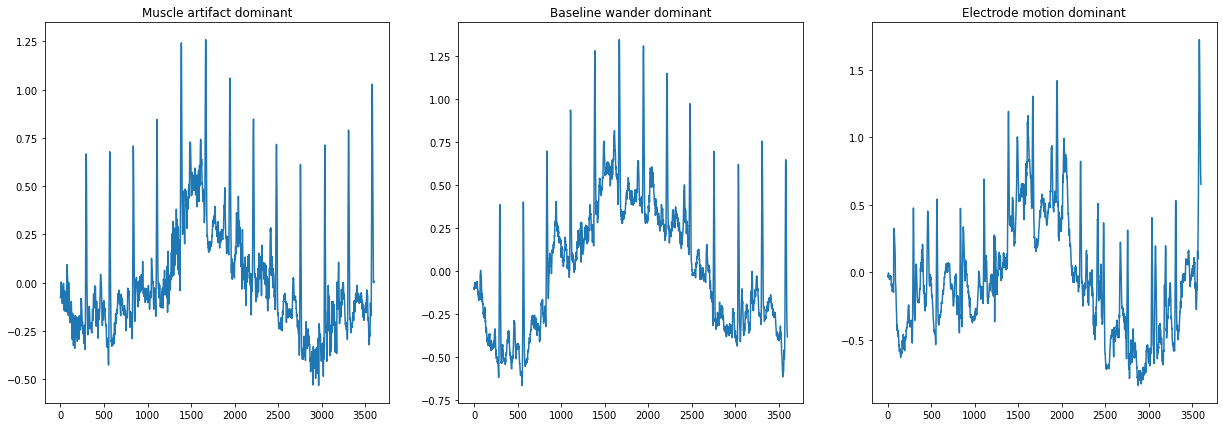

In [ ]:
# Plot noisy ECGs from 3 groups
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(7), fig.set_figwidth(21)
ax1.plot(ma_dom_group[0])
ax1.set_title('Muscle artifact dominant')
ax2.plot(bw_dom_group[0])
ax2.set_title('Baseline wander dominant')
ax3.plot(em_dom_group[0])
ax3.set_title('Electrode motion dominant')
plt.show()

##Building the network

###Imports

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, Conv1DTranspose
from tensorflow.keras.layers import BatchNormalization, MaxPool1D, UpSampling1D
from tensorflow.keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU, Subtract, Reshape
from IPython.display import SVG

from time import time
import numpy as np

###1D UNET

In [ ]:
def unet_1d(input_shape=(3600, 1), n_classes=1):
  def downstream(x, f, k_size, stride_size):
    x = Conv1D(f,k_size,activation = 'relu', padding='same')(x)
    x = Conv1D(f,k_size,activation = 'relu', padding='same')(x)
    d = Conv1D(f,k_size,activation = 'relu', padding='same')(x)
    x = MaxPool1D(strides=stride_size,padding='same')(d)
    return d,x

  def crop_merge(x, d):
    _, xw, xh = tf.keras.backend.int_shape(x)
    _, dw, dh = tf.keras.backend.int_shape(d)
    mw, mh = (dw-xw)//2, (dh-xh)//2
    d = Lambda(lambda x: x[:, mw: dw-mw, mh: dh-mh])(d)
    x = Concatenate()([d, x])
    return x

  def upstream_with_skipConnection(x, f, k_size, d, upsample_mult):
    x = UpSampling1D(size = upsample_mult)(x)
    x = crop_merge(x, d)
    x = Conv1DTranspose(f, k_size, activation='relu', padding='same')(x)
    
    x1 = Add()([x,d])
    x2 = Conv1DTranspose(f, k_size, activation='relu', padding='same')(x1)
    x2 = Add()([x2,d])
    x3 = Conv1DTranspose(f, k_size, activation='relu', padding='same')(x2)
    x_final = Add()([x3,d])
    return x_final

  def context_contrast(x_final_downsampled):
    x2 = Conv1DTranspose(96,5,activation='relu',padding='same')(x_final_downsampled)
    x2 = Conv1DTranspose(96,5,activation='relu',padding='same')(x2)
    x1 = Conv1D(96,5,dilation_rate=10,activation='relu',padding='same')(x_final_downsampled)
    x1 = Conv1D(96,5,dilation_rate=10,activation='relu',padding='same')(x1)
    z = Subtract()([x1,x2])
    x = Concatenate()([x1,z,x2])
    return x

  input = Input(input_shape)
  x = input

  downsampled = []
  d0,x0 = downstream(x, 12, 20, 10)
  downsampled.append(d0)
  d1,x1 = downstream(x0, 32, 10, 5)
  downsampled.append(d1)
  d2,x2 = downstream(x1, 48, 5, 2)
  downsampled.append(d2)

  x_new = context_contrast(x2)

  ux_2 = upstream_with_skipConnection(x_new,48,5,d2,2)
  ux_1 = upstream_with_skipConnection(ux_2,32,10,d1,5)
  ux_0 = upstream_with_skipConnection(ux_1,12,20,d0,10)

  x_out = Conv1D(1,1,padding='same')(ux_0)

  output = Dense(n_classes)(x_out)
  model = Model(input, output)
  return model

In [ ]:
input_shape = 3600, 1
num_classes = 1

K.clear_session()
model = unet_1d()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3600, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 3600, 12)     252         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 3600, 12)     2892        conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 3600, 12)     2892        conv1d_1[0][0]                   
_______________________________________________________________________________________

###Training

In [ ]:
x_train_1 = bw_dom_group[:1050]
x_validate_1 = bw_dom_group[1050: 1350]
x_test_1 = bw_dom_group[1350:len(bw_dom_group)]
print(np.array(x_train_1).shape)
print(np.array(x_validate_1).shape)
print(np.array(x_test_1).shape)

(1050, 3600)
(300, 3600)
(150, 3600)


In [ ]:
x_train_2 = em_dom_group[:1050]
x_validate_2 = em_dom_group[1050: 1350]
x_test_2 = em_dom_group[1350:len(em_dom_group)]
print(np.array(x_train_2).shape)
print(np.array(x_validate_2).shape)
print(np.array(x_test_2).shape)

(1050, 3600)
(300, 3600)
(150, 3600)


In [ ]:
x_train_3 = ma_dom_group[:1050]
x_validate_3 = ma_dom_group[1050: 1350]
x_test_3 = ma_dom_group[1350:len(ma_dom_group)]
print(np.array(x_train_3).shape)
print(np.array(x_validate_3).shape)
print(np.array(x_test_3).shape)

(1050, 3600)
(300, 3600)
(150, 3600)


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-8,clipvalue=0.5)

In [ ]:
model.compile(loss='mean_squared_error',optimizer=optimizer)

In [ ]:
noisy_ecg_train = np.array(x_train_1)
gt_ecg_train = ground_truth_ecg[:1050]
noisy_ecg_validate = np.array(x_validate_1)
gt_ecg_validate = ground_truth_ecg[1050: 1350]
noisy_ecg_test = np.array(x_test_1)
gt_ecg_test = ground_truth_ecg[1350:len(ma_dom_group)]

model.fit(noisy_ecg_train,gt_ecg_train,epochs=50,validation_data=(noisy_ecg_validate, gt_ecg_validate), verbose = 1)
model.save('unet1d_new.h5') 

Epoch 1/50
33/33 [==============================] - 41s 1s/step - loss: 0.3826 - val_loss: 0.1822
Epoch 2/50
33/33 [==============================] - 41s 1s/step - loss: 0.1036 - val_loss: 0.0564
Epoch 3/50
33/33 [==============================] - 41s 1s/step - loss: 0.0624 - val_loss: 0.0535
Epoch 4/50
33/33 [==============================] - 41s 1s/step - loss: 0.0273 - val_loss: 0.0243
Epoch 5/50
33/33 [==============================] - 44s 1s/step - loss: 0.0144 - val_loss: 0.0161
Epoch 6/50
33/33 [==============================] - 41s 1s/step - loss: 0.0095 - val_loss: 0.0117
Epoch 7/50
33/33 [==============================] - 41s 1s/step - loss: 0.0081 - val_loss: 0.0106
Epoch 8/50
33/33 [==============================] - 41s 1s/step - loss: 0.0077 - val_loss: 0.0092
Epoch 9/50
33/33 [==============================] - 41s 1s/step - loss: 0.0063 - val_loss: 0.0082
Epoch 10/50
33/33 [==============================] - 41s 1s/step - loss: 0.0054 - val_loss: 0.0080
Epoch 11/50
33/33 [

In [ ]:
new_model = tf.keras.models.load_model('unet1d_new.h5')

# Show the model architecture
new_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3600, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 3600, 12)     252         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 3600, 12)     2892        conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 3600, 12)     2892        conv1d_1[0][0]                   
_______________________________________________________________________________________

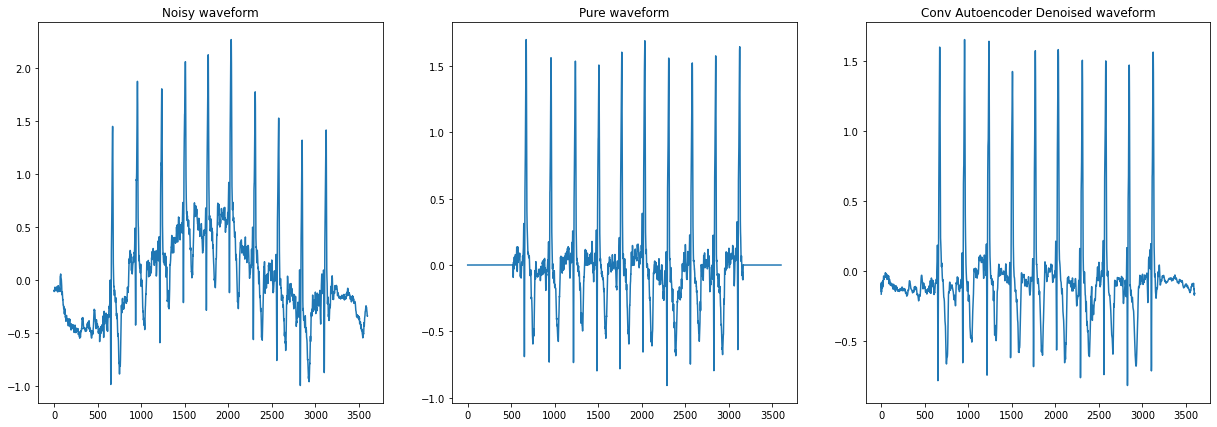

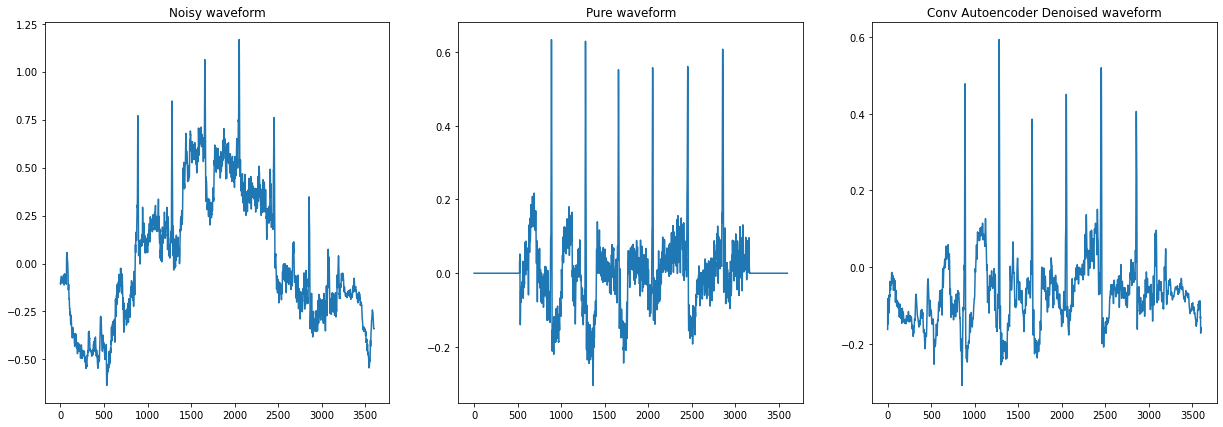

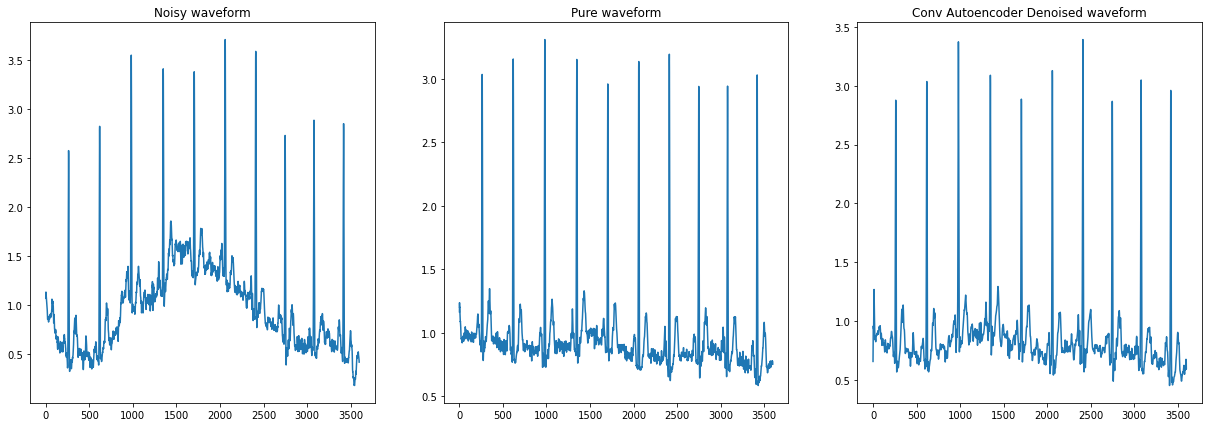

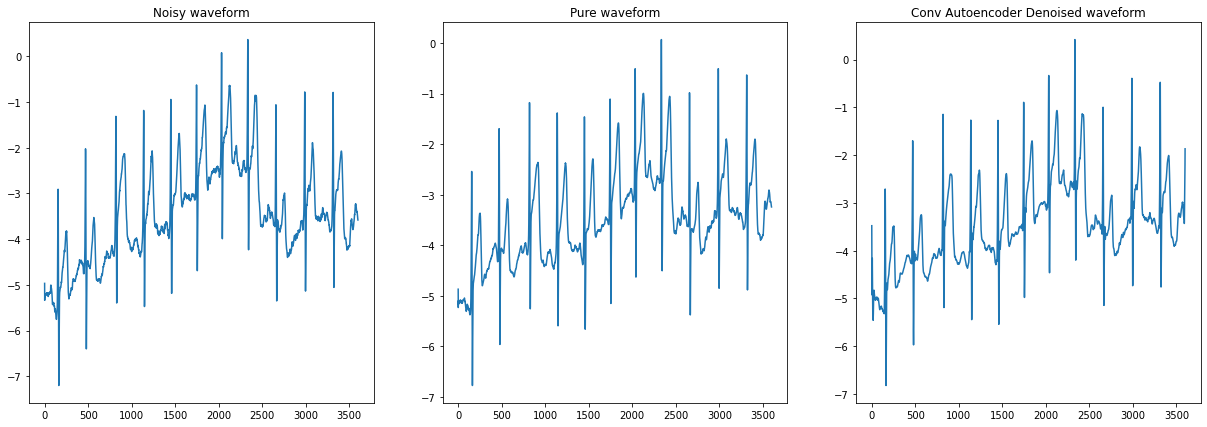

In [ ]:
num_reconstructions = len(noisy_ecg_test)
#readings = noisy_ecg_test[:num_reconstructions]
reconstructions = model.predict(noisy_ecg_test)
# Plot reconstructions
for i in np.arange(0, 4):
  # Get the sample and the reconstruction
  original = noisy_ecg_test[i]
  pure = gt_ecg_test[i]
  
  # Matplotlib preparations
  fig, axes = plt.subplots(1, 3)
  fig.set_figheight(7), fig.set_figwidth(21)
  # Plot sample and reconstruciton
  axes[0].plot(original)
  axes[0].set_title('Noisy waveform')
  axes[1].plot(pure)
  axes[1].set_title('Pure waveform')
  axes[2].plot(reconstructions[i])
  axes[2].set_title('Conv Autoencoder Denoised waveform')
  plt.show()

###Testing

In [ ]:
model.evaluate(noisy_ecg_test,gt_ecg_test)

5/5 [==============================] - 1s 292ms/step - loss: 0.0091


0.009080430492758751

###Performance metrics

In [ ]:
from math import sqrt
from scipy.stats.stats import pearsonr

class Evaluator:
    def __init__(self,y_true,y_pred):
        self.y_true = y_true
        self.y_pred = y_pred

    def mean_square_error(self):
        self.y_true = np.asmatrix(self.y_true).reshape(-1)
        self.y_pred = np.asmatrix(self.y_pred).reshape(-1)

        return np.square(np.subtract(self.y_true, self.y_pred)).mean()

    def root_mean_square_error(self):

        return self.mean_square_error()**0.5


    def mean_absolute_percentage_error(self):
        self.y_true = np.asarray(self.y_true).reshape(-1)
        self.y_pred = np.asarray(self.y_pred).reshape(-1)

        if len(np.where(self.y_true == 0)[0]) > 0:
            return np.inf
        else:
            return np.mean(np.abs((self.y_true - self.y_pred) / self.y_true)) * 100

    def symmetric_mean_absolute_percentage_error(self):
        self.y_true = np.asarray(self.y_true).reshape(-1)
        self.y_pred = np.asarray(self.y_pred).reshape(-1)

        return np.mean(np.abs((self.y_true - self.y_pred) / (( np.abs(self.y_true) + np.abs(self.y_pred) )/2) ))

    def mean_absolute_error(self):
        
        self.y_true = np.asarray(self.y_true).reshape(-1)
        self.y_pred = np.asarray(self.y_pred).reshape(-1)

        return np.mean(np.abs(self.y_true - self.y_pred))


    def u_theil(self):
        self.y_true = np.asarray(self.y_true).reshape(-1)
        self.y_pred = np.asarray(self.y_pred).reshape(-1)

        error_sup = np.square(np.subtract(self.y_true, self.y_pred)).sum()
        error_inf = np.square(np.subtract(self.y_true[0:(len(self.y_true) - 1)], self.y_true[1:(len(self.y_true))])).sum()

        return error_sup / error_inf


    def average_relative_variance(self):
        self.y_true = np.asarray(self.y_true).reshape(-1)
        self.y_pred = np.asarray(self.y_pred).reshape(-1)
        mean = np.mean(self.y_true)

        error_sup = np.square(np.subtract(self.y_true, self.y_pred)).sum()
        error_inf = np.square(np.subtract(self.y_true, mean)).sum()

        return error_sup / error_inf


    def index_agreement(self):
        self.y_true = np.asarray(self.y_true).reshape(-1)
        self.y_pred = np.asarray(self.y_pred).reshape(-1)
        mean = np.mean(self.y_true)

        error_sup = np.square(np.abs(np.subtract(self.y_true, self.y_pred))).sum()

        error_inf = np.abs(np.subtract(self.y_pred, mean)) + np.abs(np.subtract(self.y_true, mean))
        error_inf = np.square(error_inf).sum()

        return 1 - (error_sup / error_inf)


    def prediction_of_change_in_direction(self):
        self.y_true = np.asarray(self.y_true).reshape(-1)
        self.y_pred = np.asarray(self.y_pred).reshape(-1)

        true_sub = np.subtract(self.y_true[0:(len(self.y_true) - 1)], self.y_true[1:(len(self.y_true))])
        pred_sub = np.subtract(self.y_pred[0:(len(self.y_pred) - 1)], self.y_pred[1:(len(self.y_pred))])

        mult = true_sub * pred_sub
        result = 0
        for m in mult:
            if m > 0:
                result = result + 1

        return (100 * (result / len(self.y_true)))


    def pearson_coefficient(self):
        return pearsonr(self.y_pred,self.y_true)[0]

    def snr(self):
        self.y_true = np.asmatrix(self.y_true).reshape(-1)
        self.y_pred = np.asmatrix(self.y_pred).reshape(-1)
        snr = 10 * np.log10(np.square(self.y_true).sum() / np.square(np.subtract(self.y_true, self.y_pred)).sum())
        return snr

    def generate_metric_results(self):
        return {'MSE': self.mean_square_error(),
                'RMSE':self.root_mean_square_error(),
                'MAPE': self.mean_absolute_percentage_error(),
                'SMAPE':self.symmetric_mean_absolute_percentage_error(),
                'MAE': self.mean_absolute_error(),
                'theil': self.u_theil(),
                'ARV': self.average_relative_variance(),
                'IA': self.index_agreement(),
                'POCID': self.prediction_of_change_in_direction(),
                'Pearson': self.pearson_coefficient(),
                'SNR': self.snr() }

In [ ]:
metric_eval = Evaluator(y_true=gt_ecg_test[0],y_pred=reconstructions[0]) 
dict_metrics = metric_eval.generate_metric_results()
all_rmse_ip = []
all_rmse_op = []

all_pearson_in = []
all_pearson_op = []

all_snr_ip = []
all_snr_op = []

for i in range(len(noisy_ecg_test)):
  input_metric_eval = Evaluator(y_true=gt_ecg_test[i],y_pred=noisy_ecg_test[i]) 
  input_dict_metrics = input_metric_eval.generate_metric_results()
  all_rmse_ip.append(input_dict_metrics['RMSE'])
  all_pearson_in.append(input_dict_metrics['Pearson'])
  all_snr_ip.append(input_dict_metrics['SNR'])

  output_metric_eval = Evaluator(y_true=gt_ecg_test[i],y_pred=reconstructions[i]) 
  output_dict_metrics = output_metric_eval.generate_metric_results()
  all_rmse_op.append(output_dict_metrics['RMSE'])
  all_pearson_op.append(output_dict_metrics['Pearson'])
  all_snr_op.append(output_dict_metrics['SNR'])

print(
np.mean(np.subtract(np.array(all_rmse_ip),np.array(all_rmse_op))), ": Net RMSE\n",
np.mean(np.array(all_pearson_in)),":mean Pearson coeff inpt side\n",
np.mean(np.array(all_pearson_op)),": mean Pearson coeff output side\n",
np.mean(np.subtract(np.array(all_snr_op),np.array(all_snr_ip))), ": Net SNR"
)

0.24864803246905146 : Net RMSE
 0.6071123801911853 :mean Pearson coeff inpt side
 0.950940284473456 : mean Pearson coeff output side
 11.441945647949384 : Net SNR


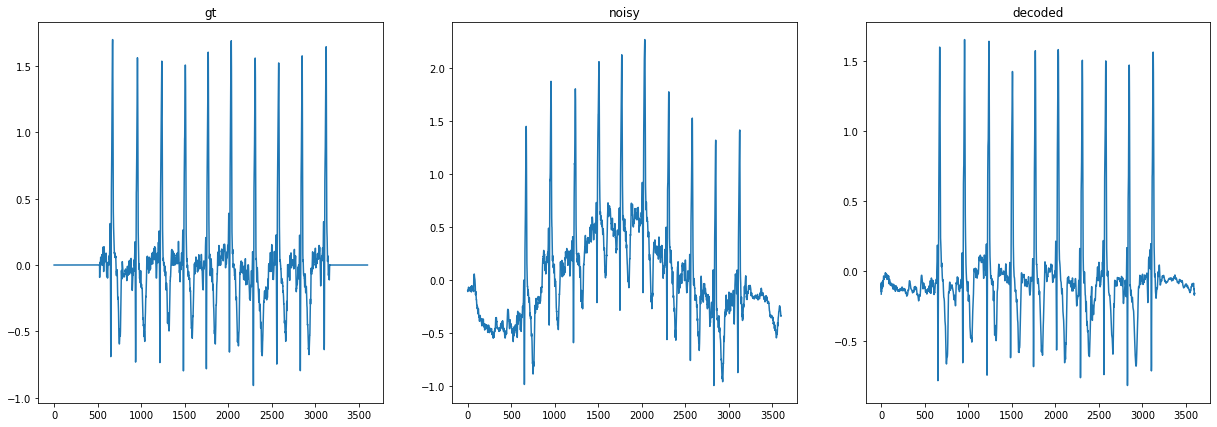

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(7), fig.set_figwidth(21)
ax1.plot(gt_ecg_test[0])
ax1.set_title('gt')
ax2.plot(noisy_ecg_test[0])
ax2.set_title('noisy')
ax3.plot(reconstructions[0])
ax3.set_title('decoded')
plt.show()

#Data preparation methods: MITBIH

In [ ]:
#for accessing the MIT database 
import wfdb
import numpy as np
from wfdb import rdsamp, rdann
from wfdb.processing import (
    resample_singlechan,
    find_local_peaks,
    correct_peaks,
    normalize_bound
)
from random import uniform
from scipy.signal import resample_poly
from wfdb import processing
from tensorflow.keras.models import load_model
from functools import partial
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
def get_beats(annotation):
    # All beat annotations
    beat_annotations = ['N', 'L', 'R', 'B', 'A',
                        'a', 'e', 'J', 'V', 'r',
                        'F', 'S', 'j', 'n', 'E',
                        '/', 'Q', 'f', '?']

    # Get indices and symbols of the beat annotations
    indices = np.isin(annotation.symbol, beat_annotations)
    symbols = np.asarray(annotation.symbol)[indices]
    beats = annotation.sample[indices]

    return beats, symbols


def signal_from_records(records,channel,db):
    signals = []
    beat_locations = []
    beat_types = []
    for record in records:
        print('processing record: ', record)
        signal, fields = rdsamp(record, pn_dir=db)
        annotation = rdann(record, 'atr', pn_dir=db)
        beat_loc, beat_type = get_beats(annotation)
        signals.append(signal[:,channel])
        beat_locations.append(beat_loc)
        beat_types.append(beat_type)

    return signals, beat_locations, beat_types

In [ ]:
#From wfdb package
from wfdb.io import get_record_list
mitdb_records = get_record_list('mitdb')
mitdb_signals_0, mitdb_beats_0, mitdb_beat_types_0 = signal_from_records(mitdb_records, channel=0, db='mitdb')
mitdb_signals_1, mitdb_beats_1, mitdb_beat_types_1 = signal_from_records(mitdb_records, channel=1, db='mitdb')

processing record:  100
processing record:  101
processing record:  102
processing record:  103
processing record:  104
processing record:  105
processing record:  106
processing record:  107
processing record:  108
processing record:  109
processing record:  111
processing record:  112
processing record:  113
processing record:  114
processing record:  115
processing record:  116
processing record:  117
processing record:  118
processing record:  119
processing record:  121
processing record:  122
processing record:  123
processing record:  124
processing record:  200
processing record:  201
processing record:  202
processing record:  203
processing record:  205
processing record:  207
processing record:  208
processing record:  209
processing record:  210
processing record:  212
processing record:  213
processing record:  214
processing record:  215
processing record:  217
processing record:  219
processing record:  220
processing record:  221
processing record:  222
processing recor

#Adding AWGN + PLI noise

(650000,)


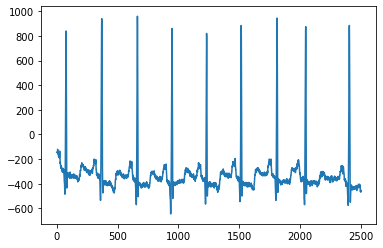

In [ ]:
ecg = mitdb_signals_0[0] * 1000
print(ecg.shape)
plt.plot(ecg[:2500])

51.177521558466886


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


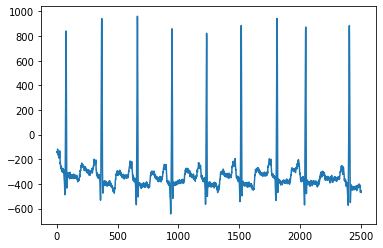

In [ ]:
#AWGN..channel noise
noise_power_db = np.array([5,10,15,20,25,30,35,40,45,50])
target_snr_db = 2
ecg_power = np.square(ecg)
ecg_db = 10 * np.log10(ecg_power)
ecg_avg_watts = np.mean(ecg_power)
ecg_avg_db = 10 * np.log10(ecg_avg_watts)
# Calculate noise according to [2] then convert to watts
#noise_avg_db = ecg_avg_db - target_snr_db
noise_avg_db = 5
print(ecg_avg_db)
noise_avg_watts = 10 ** (noise_avg_db / 10)
# Generate an sample of white noise
mean_noise = 0
noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(ecg_power))
# Noise up the original signal
noisy_ecg = ecg + noise_volts
plt.plot(noisy_ecg[:2500])

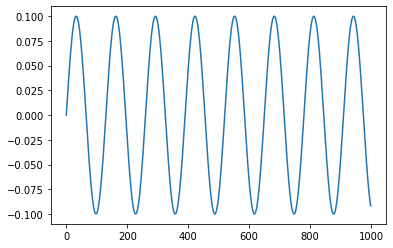

In [ ]:
#EMG
f = 5000
w = 2 * np.pi * f
time_interval = len(ecg)
samples_res = len(ecg)
t = np.linspace(0, time_interval, samples_res)
y_emg = 0.1*np.sin(w * t)
plt.plot(t[:1000], y_emg[:1000])
plt.show()

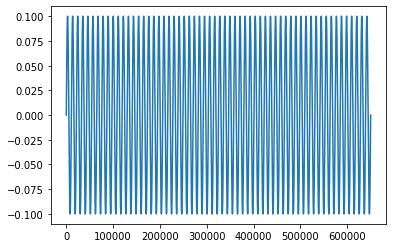

In [ ]:
#PLI
f = 60
w = 2 * np.pi * f
time_interval = len(ecg)
samples_res = len(ecg)
t = np.linspace(0, time_interval, samples_res)
y_pli = 0.1*np.sin(w * t)
plt.plot(t, y_pli)
plt.show()

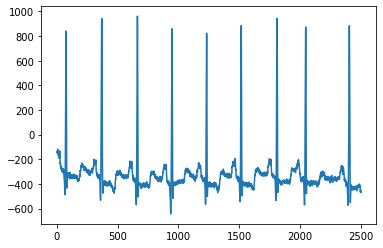

In [ ]:
final_noisy_sig = noisy_ecg + y_emg + y_pli
plt.plot(final_noisy_sig[:2500])

In [ ]:
print(noisy_ecg.shape)
print(y_emg.shape)
print(y_pli.shape)

(650000,)
(650000,)
(650000,)


In [ ]:
def getNoisyEcgHighFreq(ecgtracing,noise_avgdb):
  ecg_amplified = ecgtracing*1000
  #for AWGN
  ecg_power = np.square(ecg_amplified)
  #ecg_db = 10 * np.log10(ecg_power)
  #ecg_avg_watts = np.mean(ecg_power)
  #ecg_avg_db = 10 * np.log10(ecg_avg_watts)
  # Calculate noise according to [2] then convert to watts
  #noise_avg_db = ecg_avg_db - target_snr_db
  noise_avg_db = 5
  noise_avg_watts = 10 ** (noise_avgdb / 10)
  # Generate an sample of white noise
  mean_noise = 0
  noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(ecg_power))
  # Noise up the original signal
  noisy_ecg = ecg_amplified + noise_volts

  #EMG
  f_emg = 5000
  w_emg = 2 * np.pi * f_emg
  time_interval = len(ecg)
  samples_res = len(ecg)
  t = np.linspace(0, time_interval, samples_res)
  y_emg = 0.1*np.sin(w_emg * t)

  #PLI
  f_pli = 60
  w_pli = 2 * np.pi * f_pli
  y_pli = 0.1*np.sin(w_pli * t)

  final_noisy_sig = noisy_ecg + y_emg + y_pli
  return final_noisy_sig

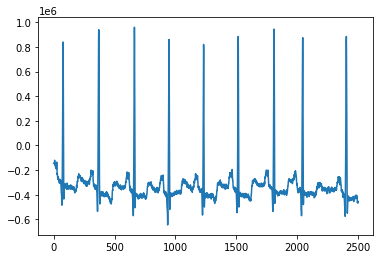

In [ ]:
plt.plot(getNoisyEcgHighFreq(ecg,5)[:2500])

#MITDB set denoising

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model(model_path)
# Show the model architecture
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3600, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 3600, 12)     252         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 3600, 12)     2892        conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 3600, 12)     2892        conv1d_1[0][0]                   
_______________________________________________________________________________________

In [ ]:
def denoise_ECG_data(signal_db):
  all_chunk_indices = []
  all_chunks = []
  i = 0
  while(i<len(signal_db)):
    all_chunk_indices.append(i)
    i += 3600

  for j in all_chunk_indices:
    if j+3600 <= len(signal_db):
      all_chunks.append(signal_db[j:j+3600])
    else:
      temp = signal_db[j:len(signal_db)]
      temp_chunk = np.pad(temp,(0,3600-len(temp)),'constant',constant_values=(0))
      all_chunks.append(temp_chunk)

  readings = np.array(all_chunks)
  reconstructions = model.predict(readings)
  den_signal = reconstructions.ravel()
  fin_den_sig = den_signal[: len(signal_db)]
  return fin_den_sig

(650000,)


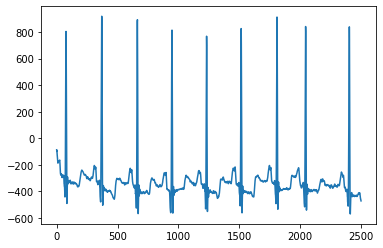

In [ ]:
#trial denoising
den_ecg = denoise_ECG_data(final_noisy_sig)
print(den_ecg.shape)
plt.plot(den_ecg[:2500])

In [ ]:
denoised_ecg_tracings_0 = []
denoised_ecg_tracings_1 = []

for i in range(len(mitdb_signals_0)):
  ecg_signal_0 = getNoisyEcgHighFreq(mitdb_signals_0[i],100)
  ecg_signal_1 = getNoisyEcgHighFreq(mitdb_signals_1[i],100)
  print(i)
  denoised_ecg_tracings_0.append(denoise_ECG_data(ecg_signal_0))
  denoised_ecg_tracings_1.append(denoise_ECG_data(ecg_signal_1))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


In [ ]:
import pandas as pd
temp_0 = {mitdb_records[i]: denoised_ecg_tracings_0[i] for i in range(len(mitdb_records))}
ecg_denoised_df_0 = pd.DataFrame(data = temp_0)
ecg_denoised_df_0.to_parquet('mit_denoised_ecg_lead0_100db.parquet')

temp_1 = {mitdb_records[i]: denoised_ecg_tracings_1[i] for i in range(len(mitdb_records))}
ecg_denoised_df_1 = pd.DataFrame(data = temp_0)
ecg_denoised_df_1.to_parquet('mit_denoised_ecg_lead1_100db.parquet')

In [ ]:
#move from temp storage to your drive
import shutil
shutil.move('/content/mit_denoised_ecg_lead0_100db.parquet', "/content/drive/My Drive")
shutil.move('/content/mit_denoised_ecg_lead1_100db.parquet', "/content/drive/My Drive")

'/content/drive/My Drive/mit_denoised_ecg_lead1_100db.parquet'